<a href="https://colab.research.google.com/github/Aragnzlz/PROJECTS/blob/main/SERIES_DE_TIEMPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tratamiento de datos
# ==============================================================================
!pip install astral # Installing the astral package
!pip install skforecast # Installing the skforecast package
import numpy as np
import pandas as pd
from astral.sun import sun # This import should now work
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelado y Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features
import shap

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión lightgbm: {lightgbm.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




ModuleNotFoundError: No module named 'skforecast.ForecasterBaseline'

In [ ]:
# Cargar datos desde un archivo Excel
datos = pd.read_excel('DATOS_E094_DIAS.xlsx')
datos #Imprimir datos

,DIA,VOLUMEN
0,01/01/2024,64.18
1,02/01/2024,81.76
2,03/01/2024,80.10
3,04/01/2024,81.22
4,05/01/2024,72.39
...,...,...
201,27/07/2024,82.80
202,28/07/2024,79.29
203,29/07/2024,83.32
204,30/07/2024,82.08


In [ ]:
# Conversión del formato fecha
# ==============================================================================
datos['DIA'] = pd.to_datetime(datos['DIA'], format='%d/%m/%Y')
datos = datos.set_index('DIA')
datos.head(2)

,VOLUMEN
DIA,
2024-01-01,64.18
2024-01-02,81.76


Uno de los primeros análisis que hay que realizar al trabajar con series temporales es verificar si la serie está completa.

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()

In [ ]:
fecha_inicio

Timestamp('2024-01-01 00:00:00')

In [ ]:
fecha_fin

Timestamp('2024-07-31 00:00:00')

In [ ]:
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)

In [ ]:
date_range_completo

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', length=213, freq='D')

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
#date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)
#print(f"Índice completo: {(datos.index == date_range_completo).all()}")
#print(f"Filas con valores ausentes: {datos.isnull().any(axis=1).mean()}")

In [ ]:
# Separación datos train-val-test
# ==============================================================================
fin_train = '2024-06-30'
fin_validacion = '2024-07-31'
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")

Fechas train      : 2024-01-01 00:00:00 --- 2024-06-30 00:00:00  (n=175)
Fechas validacion : 2024-06-30 00:00:00 --- 2024-07-31 00:00:00  (n=32)


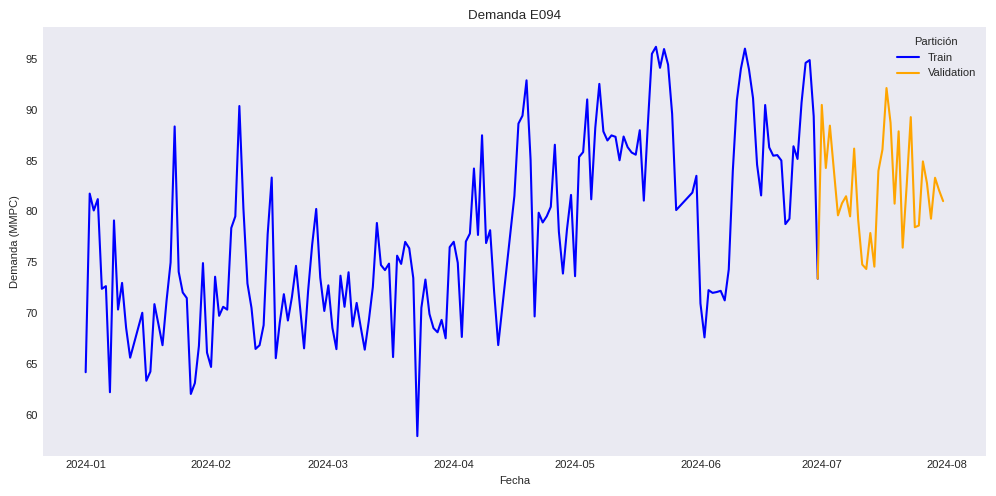

In [ ]:
# Gráfico de la serie temporal
plt.figure(figsize=(10, 5))

# Trazar los datos de entrenamiento
plt.plot(datos_train.index, datos_train['VOLUMEN'], label='Train', color='blue')
# Trazar los datos de validación
plt.plot(datos_val.index, datos_val['VOLUMEN'], label='Validation', color='orange')

# Configuración del gráfico
plt.title('Demanda E094')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MMPC)')
plt.legend(title='Partición')
plt.grid()
plt.tight_layout()

# Mostrar el gráfico
plt.show()


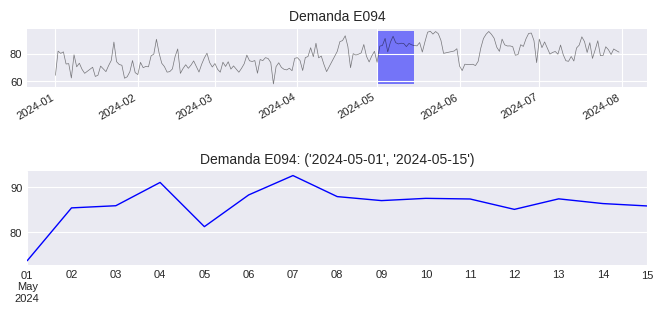

In [ ]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2024-05-01','2024-05-15')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
datos.VOLUMEN.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.VOLUMEN)
max_y = max(datos.VOLUMEN)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
datos.loc[zoom[0]: zoom[1]].VOLUMEN.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Demanda E094', fontsize=10)
zoom_ax.set_title(f'Demanda E094: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)


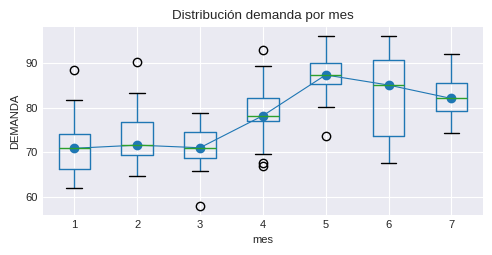

In [ ]:
# Distribución de la demanda por mes
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
datos['mes'] = datos.index.month
datos.boxplot(column='VOLUMEN', by='mes', ax=ax,)
datos.groupby('mes')['VOLUMEN'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('DEMANDA')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

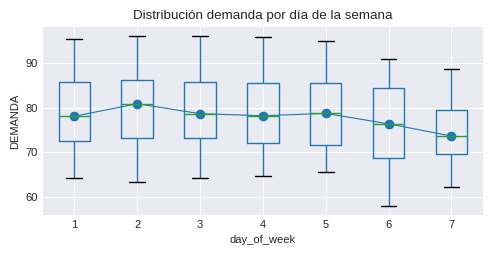

In [ ]:
# Distribución de la demanda por día de la semana
# ==============================================================================
fig, ax = plt.subplots(figsize=(5.5, 2.5))
# Create a temporary column for the day of the week to avoid ambiguity.
datos['day_of_week'] = datos.index.day_of_week + 1
datos.boxplot(column='VOLUMEN', by='day_of_week', ax=ax) # Use the temporary column for grouping.
datos.groupby('day_of_week')['VOLUMEN'].median().plot(style='o-', linewidth=0.8, ax=ax) # Use the temporary column here too.
ax.set_ylabel('DEMANDA')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



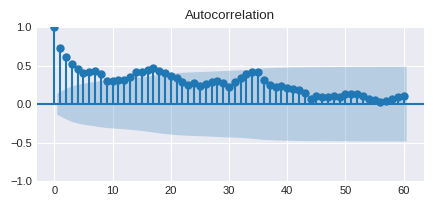

In [ ]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(datos.VOLUMEN, ax=ax, lags=60)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



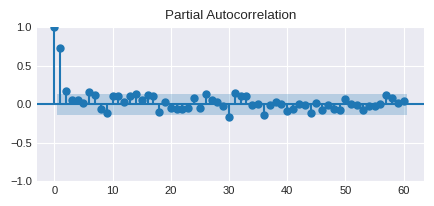

In [ ]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(datos.VOLUMEN, ax=ax, lags=60)
plt.show()

Relación significativa de los dias de la semana y la demanda

In [ ]:
# Crear el forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 24
             )

# Entrena el forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'VOLUMEN'])
forecaster

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

/usr/local/lib/python3.10/dist-packages/skforecast/utils/utils.py:1125: UserWarning:

Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_modu

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [0, 205] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-11-01 17:19:12 
Last fit date: 2024-11-01 17:19:12 
Skforecast version:

In [ ]:
train_size = len(datos_train)

In [ ]:
# Backtesting
# ==============================================================================
# Assuming 'datos' has a DateTimeIndex named 'FECHA'
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['VOLUMEN'],
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(datos) - 7 * 3, # Adjust to your data size and forecasting horizon
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = True,
                            show_progress      = True,
                            # Add the following line to ensure index alignment
                            index              = datos.DIA # Assuming your index is named 'FECHA'
                        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



TypeError: backtesting_forecaster() got an unexpected keyword argument 'index'